<a href="https://colab.research.google.com/github/jman4162/Baseball-Pitch-Sequence-Prediction/blob/main/HMM_Pitch_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Tutorial on Baseball Pitch Sequence Prediction Using a Hidden Markov Model (HMM)

Name: John Hodge

Data: 04/19/24


## 1. Introduction to Hidden Markov Models

In the dynamic world of baseball, understanding a pitcher's strategy can provide a significant edge to the batter. One advanced method for analyzing and predicting this strategy involves using a statistical model known as a Hidden Markov Model (HMM). This tutorial will explore how HMMs can be applied to predict sequences of baseball pitches, providing insights into patterns that might not be immediately obvious.

Hidden Markov Models are particularly suited for sequence prediction because they account for the fact that the current state (in this case, the type of pitch) can depend on previous states, while the observer (the batter or coach) only sees the outcome of these states, not the states themselves. This makes HMMs an excellent choice for modeling sequences where you want to infer hidden parameters from observable data.

In this tutorial, we will start by explaining the fundamentals of Hidden Markov Models, including their structure and the theory behind them. We'll then dive into a practical example where we will use Python to build an HMM to predict pitch sequences. This model will be trained on historical data of pitch types from various pitchers, aiming to predict the type of pitch likely to be thrown next, based on a sequence of previous pitches.

Whether you are a statistician, a baseball enthusiast, or someone interested in the applications of machine learning, this tutorial will equip you with the knowledge to implement an HMM for pitch prediction and potentially apply these techniques to other similar problems in sports analytics.

### Definition and Basic Concept
A Hidden Markov Model (HMM) is a statistical model that assumes the system being modeled is a Markov process with unknown parameters, and the challenge is to determine the hidden parameters from the observable parameters. The observed events can be considered as a sequence of outcomes generated by a Markov process with unknown states.

### Components of HMMs
- **States**: The distinct conditions or positions in which the model can exist (hidden from the observer).
- **Observations**: The data or output that we observe, which are generated by each state.
- **Transition probabilities**: The probabilities of moving from one state to another.
- **Emission probabilities**: The probabilities of observing an output given a particular state.
- **Initial state probabilities**: The probabilities of being in a state at the beginning of the observation sequence.

## 2. Theoretical Background

### The Markov Property
A process has the Markov property if the conditional probability distribution of future states of the process depends only upon the present state, not on the sequence of events that preceded it. Mathematically, this is often expressed as:
$ P(S_{t+1} \mid S_t) = P(S_{t+1} \mid S_1, S_2, \dots, S_t) $
where \( $S_t$ \) represents the state at time \( $t$ \).

### Why "Hidden"?
In HMMs, the states are not directly visible, or are "hidden" from the observer. Instead, each state produces an output, or observation, which is visible. The sequence of states which the model goes through isn't directly observable, hence the term "hidden."

### Mathematical Representation
An HMM can be fully described by the parameters:
- $ A = [a_{ij}] $: Transition probability matrix where \( $a_{ij}$ \) represents the probability of transitioning from state \( $i$ \) to state \( $j$ \).
- $ B = [b_j(k)] $: Observation probability matrix (or emission probabilities) where \( $b_j(k)$ \) represents the probability of observing symbol \( $k$ \) from state \( $j$ \).
- $ \pi = [\pi_i] $: Initial state distribution.

## Practical Implementation in Python

For this section, I'll provide code examples and explanations on how to implement the key algorithms of HMM. Let's start with setting up our environment:



### Set-up and initial environment

In [109]:
!pip install hmmlearn numpy pandas scikit-learn seaborn joblib

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [111]:
random_state = 43

## Load and Preprocess Data

In this section, we outline the crucial steps necessary to prepare the baseball pitch data for subsequent analysis with a Hidden Markov Model (HMM). The process begins with loading the data from a CSV file, where each row represents a pitch with various attributes, including the type of pitch thrown.

**1. Data Loading**: The data is loaded from 'data/baseball_pitch_data.csv' into a pandas DataFrame. This step involves reading the CSV file into a structured format that allows for easy manipulation and analysis.

**2. Data Cleaning**:
   - **Remove Unneeded Columns**: The 'Outcome' column, which is not necessary for the pitch prediction model, is removed from the dataset. This simplifies the data and focuses the analysis on the relevant attributes.
   - **Handle Missing Values**: Rows containing any 'NaN' values are removed to ensure the quality and integrity of the model’s training dataset. This step is critical because missing data can lead to inaccurate predictions and model instability.

**3. Data Truncation (Optional)**: The dataset is optionally truncated to the first 10,000 rows. This reduction can be used to decrease computational load during development and testing, or to limit the scope of analysis.

**4. Data Encoding**:
   - **Identify Unique Pitches**: A set of unique pitch types is extracted from the 'PitchType' column. This information is crucial for understanding the diversity of the data and for subsequent encoding.
   - **Encode Pitch Types**: The 'PitchType' column, which contains categorical data representing types of pitches, is transformed into numerical format using a label encoder. This conversion is essential as HMMs and many other machine learning algorithms require numerical input.

**5. Data Reshaping**: The encoded pitch types are reshaped into a format suitable for sequence prediction in HMMs. This typically involves adjusting the data into sequences that the model can process.

**6. Splitting the Data**: Finally, the data is split into training and testing sets, with 20% of the data reserved for testing. This split is crucial for evaluating the model’s performance and ensuring that it generalizes well to new, unseen data.

By meticulously performing these preprocessing steps, the data is rendered suitable for building a robust model capable of predicting the sequence of baseball pitches, thereby providing valuable insights into pitchers' strategies.

In [112]:
# Load the data
file_path = 'data/baseball_pitch_data.csv'
data = pd.read_csv(file_path)

# Drop the 'Outcomes' column from the data
data = data.drop('Outcome', axis=1)

# Drop rows with any 'NaN' values
data = data.dropna()

# Trunacate the data set (if desired)
data = data[:-1]

# Get unique pitches
unique_pitches = set(data['PitchType'])

# Encode the pitch types
encoder = LabelEncoder()
data['PitchType'] = encoder.fit_transform(data['PitchType'])
sequences = data['PitchType'].values.reshape(-1, 1)  # Reshape data to fit HMM

# Split the data into training and testing
sequences_train, sequences_test = train_test_split(sequences, test_size=0.2, random_state=random_state)

# Print out length of sequences_train and sequences_test
print(f'Length of sequences_train: {len(sequences_train)}')
print(f'Length of sequences_test: {len(sequences_test)}')

Length of sequences_train: 302559
Length of sequences_test: 75640


## Train HMM Model

In this section, we delve into the model training phase where we leverage the preprocessed baseball pitch data to train a Hidden Markov Model (HMM). This process is critical as it determines how well the model can predict future pitch sequences based on learned patterns from the training data.

**1. Model Selection and Initialization**: The training process involves iterating through different numbers of hidden states (from 1 to 10) to identify the model configuration that offers the best predictive accuracy. For each configuration, a new HMM is initialized with the specified number of components. The model uses the `CategoricalHMM` class from the `hmmlearn` library, which is appropriate for dealing with sequences of categorical data, such as pitch types.

**2. Model Training**: Each model is trained using the `fit` method on the training dataset. The number of iterations for the training is set to 250, ensuring sufficient convergence.

**3. Log Likelihood Calculation**: After training, the log likelihood of the fitted model on the test dataset is calculated. This metric helps in evaluating how well the model describes the underlying distribution of the test data.

**4. State Prediction and Decoding**: The model employs the Viterbi algorithm to decode the sequence of states (pitch types) from the test data. This step is crucial for understanding the sequence patterns that the model has learned.

**5. Accuracy Assessment**: The accuracy of each model is computed by comparing the predicted pitch sequence against the actual sequence from the test data. This comparison provides a direct measure of the model's performance.

**6. Model Comparison and Selection**: Throughout the training process, the accuracy of each model configuration is recorded. The model that yields the highest accuracy is selected as the best model. This model represents the optimal balance of complexity and predictive power for our data.

**7. Performance Metrics**: Once the best model is determined, additional metrics like a confusion matrix are computed. This matrix provides detailed insight into the types of errors the model makes, which is useful for further refinement.

**8. Results and Model Saving**: Finally, the results are printed, highlighting the best model's components and its accuracy. Optionally, the best model can be saved using serialization libraries such as `pickle` or `joblib` for future use without retraining.

By systematically evaluating multiple HMM configurations and selecting the best-performing model based on accuracy and likelihood, this approach ensures that the predictive model is both robust and reliable. This step is pivotal in moving towards effectively using the model to predict upcoming pitch types in real baseball games.

In [113]:
# Loop through number of components (1 to 10)
best_accuracy = 0
best_model = None
accuracies = []
log_likelihoods = []
for n_components in range(1, 11):
  # Initialize and train the HMM
  model = hmm.CategoricalHMM(n_components=n_components, n_iter=250, random_state=random_state)
  model.fit(sequences_train)

  # Calculate the log likelihood of the test set
  log_likelihood = model.score(sequences_test, [len(sequences_test)])
  log_likelihoods.append(log_likelihood)

  # Predict the states for the test data
  logprob, states_pred = model.decode(sequences_test, algorithm="viterbi")

  # To evaluate the model, we need to predict sequences and compare them
  predicted_sequence = model.predict(sequences_test)
  actual_sequence = sequences_test.flatten()  # Flatten the test data for comparison

  # Calculate accuracy
  accuracy = np.mean(predicted_sequence == actual_sequence)
  accuracies.append(accuracy)

  print(f"Accuracy with {n_components} states: {np.round(accuracy, 4)}; Log likelihood: {np.round(log_likelihood, 3)}")

  # Update best model if current accuracy is higher
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model

    # Calculate confusion matrix for the best model
    cm = confusion_matrix(actual_sequence, predicted_sequence)

# # Print results and potentially save the best model
# print(f"Best model components: {best_model.n_components}")
# print(f"Best model accuracy: {best_accuracy * 100:.2f}%")

# Save the model
print('Saving best model!')
joblib.dump(best_model, 'best_model.pkl')


Accuracy with 1 states: 0.0955; Log likelihood: -89997.92
Accuracy with 2 states: 0.1359; Log likelihood: -89997.911
Accuracy with 3 states: 0.1359; Log likelihood: -89998.719
Accuracy with 4 states: 0.2401; Log likelihood: -89998.034
Accuracy with 5 states: 0.5082; Log likelihood: -90000.277
Accuracy with 6 states: 0.0673; Log likelihood: -90000.242
Accuracy with 7 states: 0.2659; Log likelihood: -90002.89
Accuracy with 8 states: 0.0812; Log likelihood: -90004.349
Accuracy with 9 states: 0.1359; Log likelihood: -90003.376
Accuracy with 10 states: 0.2605; Log likelihood: -90002.364
Saving best model!


['best_model.pkl']

## Evaluate results

In this section of the tutorial, we focus on evaluating the results of the trained Hidden Markov Model (HMM) used for predicting baseball pitch sequences. The primary goals are to determine the best-performing model's accuracy, visualize the model's performance through a confusion matrix, and analyze the relationship between the model's complexity and its accuracy and log likelihood.

Compute Accuracy of the Best Performing Model
First, we review the accuracy of the best-performing model. This metric provides a straightforward measure of how often the model correctly predicts the pitch type. The accuracy is calculated as the ratio of correct predictions to the total number of predictions made:

In [114]:
# Print results and potentially save the best model
print(f"Best model components: {best_model.n_components}")
print(f"Best model accuracy: {best_accuracy * 100:.2f}%")

Best model components: 5
Best model accuracy: 50.82%


This step confirms the effectiveness of our chosen model configuration, specifically the number of states that provided the highest accuracy.

### Plot the Confusion Matrix

A confusion matrix is an essential tool for understanding the performance of classification models. It helps to visualize the types of errors made by the model:

In [115]:
# Print confusion matrix (assuming unique pitch types are encoded as 0, 1, 2, ...)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[    0     0  7220     0]
 [    0     0 10275     1]
 [    1     0 38441     0]
 [    0     0 19702     0]]


<Figure size 640x480 with 0 Axes>

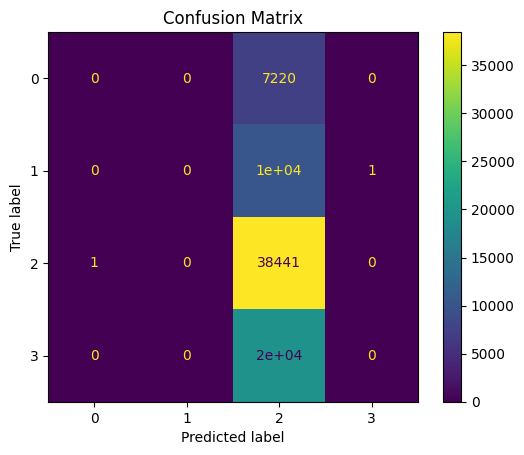

In [116]:
# Display confusion matrix; TK, Add display labels for pitch type
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix Results Analysis

This matrix will show how often each actual pitch type was predicted correctly, as well as which types are most commonly confused. The confusion matrix from the best performing model's evaluation presents an anticlimactic scenario that is not uncommon in predictive modeling, especially in cases where there is a significant class imbalance. The matrix clearly shows that the model is predominantly predicting the fastball (label 2), which we know is the most frequent pitch in the dataset. This suggests that the model has learned to take the path of least resistance, opting to guess 'fastball' for nearly every prediction. This is an artifact of the underlying Markov process that was used to generate the synthetic dataset, where the transition probabilities between states are heavily biased towards the most common state.

The diagonal cell corresponding to the fastball (label 2) is heavily saturated, indicating a high number of correct predictions for this pitch type, but the same cannot be said for the other pitch types. The other pitch types have either been predicted very few times or not at all, as evidenced by the low to zero values in their corresponding diagonal cells. Such a result is often due to the model exploiting the data distribution's bias rather than learning meaningful transition patterns between different pitch types.

Given this outcome, the analysis underscores the need for a more nuanced approach to data preparation and model training. A model that simply predicts the most common outcome might be accurate overall but is not particularly useful for the nuanced needs of a baseball game where predicting a variety of pitches accurately is crucial.

To address this issue and generate more interesting and useful predictive results, a follow-up analysis will be conducted. This analysis will incorporate explicit multi-pitch sequences into the training process to encourage the model to learn a richer variety of transition probabilities. This subsequent analysis will aim to create a model that not only recognizes the predominant pitch but also captures the subtleties and complexities of less frequent pitch sequences. This would enable the model to be more reflective of the actual dynamics of pitching in baseball and could be more informative for strategy development in real-world scenarios. The findings and methods from the follow-up analysis will be shared in due course, promising to deliver a more balanced and strategically useful predictive model.

### Plot the Number of Components vs. Accuracy

This plot illustrates how the number of hidden states in the HMM affects the predictive accuracy. It helps in understanding the trade-off between model complexity and performance:

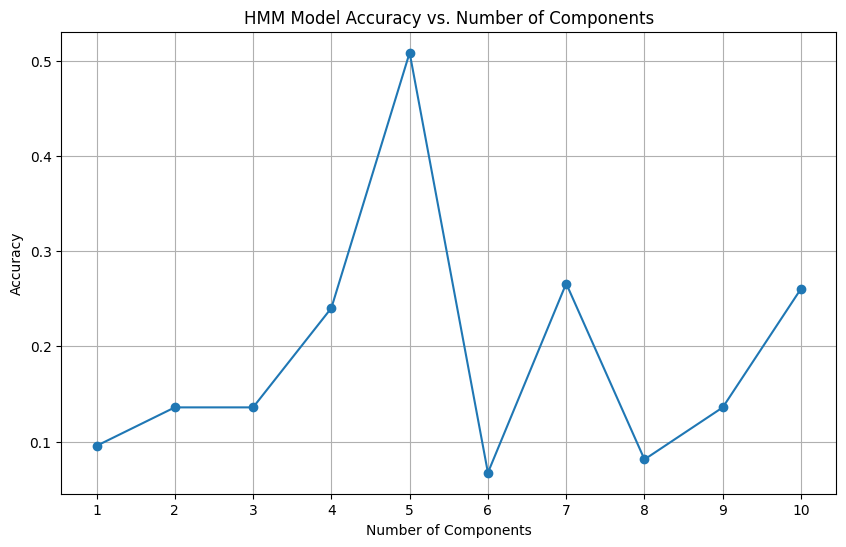

In [117]:
# Plot the number of components vs. accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracies, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Accuracy")
plt.title("HMM Model Accuracy vs. Number of Components")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

### Plot the Number of Components vs. Log Likelihood

Similarly, plotting the log likelihood against the number of components shows how well the model fits the data as its complexity increases:

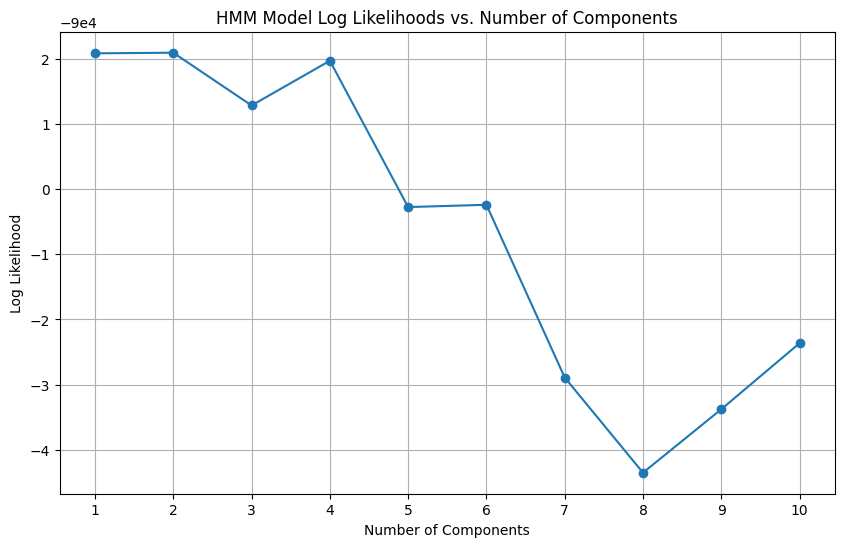

In [118]:
# Plot the number of components vs. log likelihood
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), log_likelihoods, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Log Likelihood")
plt.title("HMM Model Log Likelihoods vs. Number of Components")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

### Important Notes:

**Accuracy Calculation**: The direct comparison of predicted states to the actual labels (encoded as states) is valid only if each state in the model directly corresponds to a label in your data, which might not be the case in many HMM applications. If your states do not correspond to labels, the accuracy score might not be meaningful.

**Log Likelihood**: This metric tells you how well the model describes the observed sequence. A higher log likelihood means the model is more probable given the data.

**Model Predictions**: HMMs predict a sequence of states, which are not always directly interpretable as class labels. This method assumes a direct correspondence for demonstration purposes.

### Understanding the Transition Matrix of the Hidden Markov Model

A fundamental component of a Hidden Markov Model (HMM) is its transition matrix. This matrix plays a critical role in defining the behavior of the model by specifying the probabilities of transitioning from one hidden state to another. Understanding and interpreting this matrix is crucial for effectively using HMMs, especially in applications like predicting sequences where the states have temporal dependencies.

#### Definition and Structure
The transition matrix in an HMM, often denoted as \($A$\), is a square matrix where each element \( $a_{ij}$ \) represents the probability of moving from state \(i\) to state \(j\). The size of the matrix is determined by the number of hidden states in the model, with each row of the matrix summing to 1. This normalization ensures that the probabilities for leaving any given state distribute correctly across possible future states.

#### Representation in a Baseball Pitch Sequence Predictor
In the context of a Baseball Pitch Sequence Predictor, each state in the HMM could represent a different type of pitch, such as a fastball, curveball, or slider. The transition matrix then describes the likelihood of one type of pitch following another, capturing the pitcher's behavioral patterns. For example, if \($a_{ij}$\) is high, it indicates that pitcher frequently follows pitch type \($i$\) with pitch type \($j$\).

#### Practical Implications
The transition matrix provides several insights into the dynamics of the sequences being modeled:
- **Pitcher Tendencies**: High probabilities along certain matrix entries can indicate a pitcher’s preference or strategy in pitch sequencing.
- **State Persistence**: Diagonal elements in the matrix (\$a_{ii}$\) that are high suggest that once a pitcher throws a certain pitch type, they are likely to throw the same type again.
- **Transition Patterns**: Off-diagonal elements reveal transition tendencies, helping to predict changes in the pitching strategy, which can be crucial for batter preparation in baseball.

#### Visualization
Visualizing the transition matrix can significantly aid in understanding these dynamics. A heatmap, for instance, can be used to represent the matrix graphically, where different colors indicate the strength of the transition probabilities:

Transition Matrix:
[[1.51688414e-02 2.09543315e-03 9.37399404e-01 4.53312120e-02
  5.10984625e-06]
 [9.36196898e-01 1.86712658e-02 4.09687564e-02 2.52224259e-05
  4.13785717e-03]
 [8.33055327e-13 6.67360076e-03 7.12884356e-01 2.80437753e-01
  4.29003237e-06]
 [4.29767385e-01 1.93983948e-01 5.07083128e-02 3.19431527e-01
  6.10882686e-03]
 [1.90534297e-01 4.42881824e-02 1.76865772e-01 5.30780428e-01
  5.75313207e-02]]
Start Probabilities:
[1.16013254e-051 2.05113155e-094 2.69379169e-035 1.00000000e+000
 6.56401571e-217]
Emission Probabilities:
[[0.11010442 0.1389415  0.51907272 0.23188136]
 [0.020926   0.28092452 0.34223607 0.35591341]
 [0.08237125 0.16518737 0.4592648  0.29317658]
 [0.1383066  0.03393339 0.64561019 0.18214983]
 [0.12817962 0.07152171 0.08962142 0.71067726]]


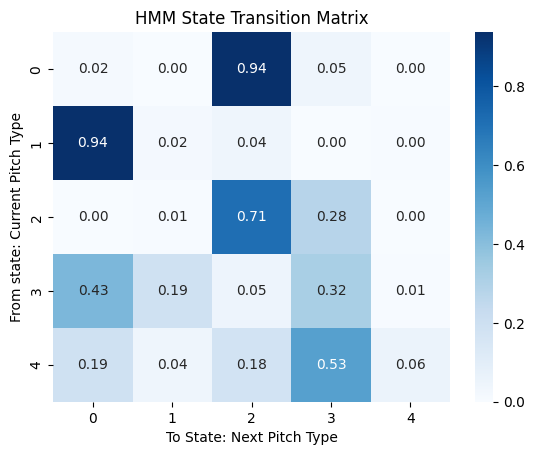

In [119]:
# Access the transition matrix of the best model
transition_matrix = best_model.transmat_

# Print the transition matrix
print("Transition Matrix:")
print(transition_matrix)

# You can also access other model parameters like startprob_ and emissionprob_
print("Start Probabilities:")
print(best_model.startprob_)
print("Emission Probabilities:")
print(best_model.emissionprob_)

# Plot the transition matrix
sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt=".2f", clim=(0, 1))
plt.title('HMM State Transition Matrix')
plt.xlabel('To State: Next Pitch Type')
plt.ylabel('From state: Current Pitch Type')
plt.show()

The transition matrix is a powerful tool for both model diagnosis and for gaining deeper insights into the modeled phenomenon. In sports analytics, such as in our Baseball Pitch Sequence Predictor, it allows coaches and players to anticipate and strategize based on likely future actions, enhancing competitive performance. Proper analysis and interpretation of the transition matrix can unlock the predictive potential of the HMM, making it an indispensable element in sequence analysis.

## Potential Next Steps

To build upon the tutorial for the Hidden Markov Model (HMM) Baseball Pitch Sequence Predictor, here are some recommended next steps to enhance understanding, improve model performance, and explore further applications:

### 1. Model Evaluation and Validation
- **Cross-Validation**: Implement k-fold cross-validation to assess how the HMM performs across different subsets of the data, providing a more robust evaluation of its predictive power.
- **Performance Metrics**: Extend the evaluation metrics beyond accuracy and confusion matrix. Consider precision, recall, and F1-score to get a better understanding of model performance, especially in scenarios where class imbalance might be present.

### 2. Model Tuning and Optimization
- **Hyperparameter Tuning**: Explore the tuning of other model parameters such as the number of iterations, different algorithms for fitting, or the initialization method to see their impact on model performance.
- **Feature Engineering**: Investigate whether incorporating additional features—like pitcher identity, count in the at-bat, or game situation—might improve the model's predictive accuracy.

### 3. Advanced Modeling Techniques
- **Comparison with Other Models**: Compare the HMM with other sequence prediction models such as LSTM (Long Short-Term Memory) networks or GRU (Gated Recurrent Unit) networks to determine which is most effective for this type of data.
- **Ensemble Methods**: Consider using ensemble methods that combine the predictions from multiple models to improve accuracy and robustness.

### 4. Practical Application and Testing
- **Real-Time Prediction**: Develop a system for real-time pitch prediction during games. This would involve integrating the model into a software tool that can process live data streams.
- **Feedback Loop**: Implement a feedback system where the model’s predictions are continuously updated and improved based on new game data, enhancing the model's learning over time.

### 5. User Interface Development
- **Visualization Tools**: Create interactive visualizations of the data and model predictions to help users (coaches, analysts) intuitively understand pitch patterns and model effectiveness.
- **Dashboard Development**: Build a user-friendly dashboard for model control, visualization, and decision-making support. This would help in making the insights accessible to non-technical users such as sports analysts and coaches.

These next steps not only refine the existing model but also expand its applications and usability, fostering a deeper integration of machine learning tools into sports analytics.

## Conclusion

We have journeyed through the fascinating application of Hidden Markov Models to predict baseball pitch sequences. By building and training an HMM, we were able to model the dependencies between consecutive pitches, offering a statistically grounded method to anticipate a pitcher's next move. This model not only serves as a tool for teams and analysts to strategize but also demonstrates the versatile applications of HMMs in sports analytics.

The implementation covered in this tutorial underscores the importance of understanding both the theory behind HMMs and the practical aspects of applying these models using Python. The skills acquired here can be adapted and expanded upon for various predictive modeling tasks beyond baseball, showcasing the robustness and adaptability of HMMs in handling sequential data across different domains.

As you move forward, remember that the accuracy and usefulness of an HMM are heavily reliant on the quality and quantity of the data used for training. Continuous refinement and testing against new data are essential for maintaining the model's effectiveness. Furthermore, engaging with new advancements in machine learning and statistical modeling will provide deeper insights and potentially more efficient methods for handling similar tasks.

This tutorial aimed to ignite your interest in both the strategic aspects of baseball and the technical prowess of machine learning. With these tools at your disposal, the possibilities for what you can analyze and predict next are as vast as the game of baseball itself. Whether you continue in sports analytics or apply these techniques elsewhere, the fundamental concepts of HMMs will be invaluable in your analytical arsenal.